In [10]:
import sys
sys.path.insert(0,'../code')

In [11]:
import torch
import matplotlib.pyplot as plt

from datamodules.image_classification import CIFAR10DataModule
from transformers import ViTFeatureExtractor, ViTForImageClassification
from models.interpretation import ImageInterpretationNet
from torchvision.transforms.functional import normalize
from utils.plot import smoothen, draw_mask_on_image, draw_heatmap_on_image
from datamodules.transformations import UnNest

# Load test data and model

In [14]:
vit = ViTForImageClassification.from_pretrained("tanlq/vit-base-patch16-224-in21k-finetuned-cifar10")

diffmask = ImageInterpretationNet.load_from_checkpoint('../checkpoints/diffmask_MSE.ckpt')
diffmask.set_vision_transformer(vit)

feature_extractor=ViTFeatureExtractor.from_pretrained(
    "tanlq/vit-base-patch16-224-in21k-finetuned-cifar10", return_tensors="pt"
)
feature_extractor = UnNest(feature_extractor)

dm = CIFAR10DataModule(feature_extractor=feature_extractor, batch_size=200)
dm.prepare_data()
dm.setup()
dt = iter(dm.test_dataloader())
images, labels = next(dt)

Files already downloaded and verified
Files already downloaded and verified


# Keep 9 samples from each class

In [15]:
indices = []
samples_per_class = 9
images_ = None

for i in range(10):
    indices = list((labels == i).nonzero())[:samples_per_class]
    if images_ is None:
        images_ = images[indices,:,:,:]
    else:
        images_ = torch.cat([images_, images[indices, :, :, :]])

images = images_
rgb_images = [normalize(image, [-0.5, -0.5, -0.5], [2, 2, 2]).permute(1, 2, 0).clip(0, 1) for image in images]

# Get the masks and visualize results

In [16]:
# Compute masks
diff_masks = diffmask.get_mask(images[:10])["mask"].detach()
for i in range(10, len(images), 10):
    diff_masks = torch.cat([diff_masks, diffmask.get_mask(images[i:i+10])["mask"].detach()])

FileNotFoundError: [Errno 2] No such file or directory: 'figures/planes.jpg'

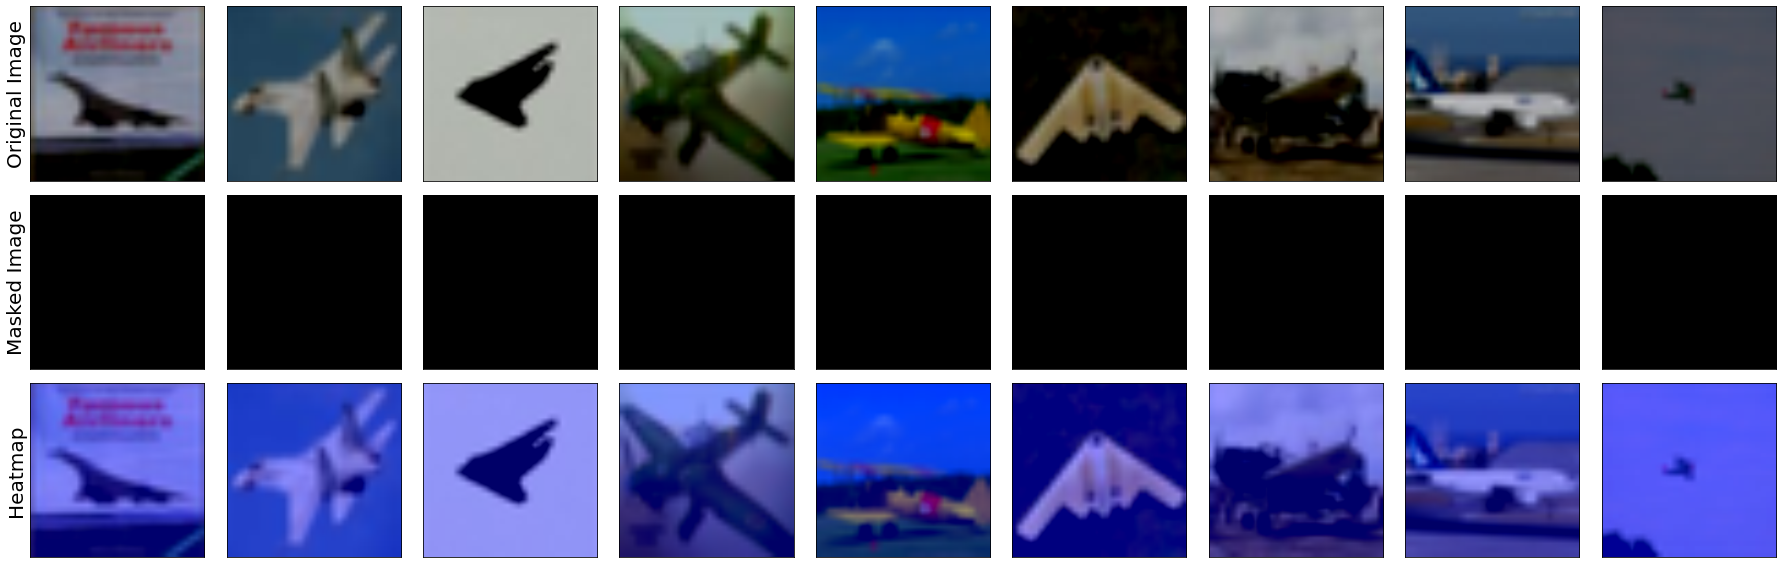

In [17]:
draw_mask = lambda image, mask: draw_mask_on_image(image.permute(2, 0, 1), smoothen(mask)).permute(1, 2, 0).clip(0, 1).numpy()
draw_heatmap = lambda image, mask: draw_heatmap_on_image(image.permute(2, 0, 1), smoothen(mask)).permute(1, 2, 0).clip(0, 1).numpy()
    
def plot_masks(rgbims, diffmasks, class_name):
    rows = 3
    columns = samples_per_class
    fig, ax = plt.subplots(rows, columns, figsize=(25, 8))

    # Remove axes
    for i in range(rows):
        for j in range(columns):
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

    font_size = 20
    for j in range(samples_per_class):
        if j==0:
            ax[0, j].set_ylabel("Original Image", fontsize=font_size)
            ax[1, j].set_ylabel("Masked Image", fontsize=font_size)
            ax[2, j].set_ylabel("Heatmap", fontsize=font_size)
            
        ax[0, j].imshow(rgbims[j])
        ax[1, j].imshow(draw_mask(rgbims[j], diffmasks[j]))
        ax[2, j].imshow(draw_heatmap(rgbims[j], diffmasks[j]))

    fig.tight_layout()
    fig.savefig(class_name + ".jpg")
    
classes = ['planes', 'cars', 'birds', 'cats', 'deers', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
for j, i in enumerate(range(0, samples_per_class*10, samples_per_class)):
    plot_masks(rgb_images[i:i + samples_per_class], diff_masks[i:i + samples_per_class], 'figures/'+classes[j])

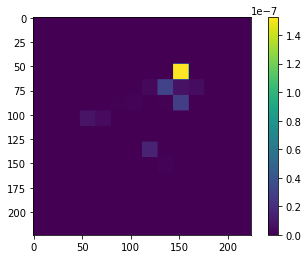

In [38]:
plt.imshow(diff_masks[2])
plt.colorbar()